# Done Soon? Data Analysis

## Import Libraries

In [219]:
import random
import sqlite3
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, RocCurveDisplay
from sklearn.preprocessing import MaxAbsScaler
from sklearn.inspection import permutation_importance
from sklearn.metrics import f1_score
import pymongo
import plotly.express as px
import math
from enum import Enum

## Notebook Configuration

In [220]:
class InstanceType(Enum):
    ALL = 1
    OPTIMIZATION = 2
    SAT = 3

data_types_to_consider = InstanceType.OPTIMIZATION

## Get Data - Mongodb

In [221]:
def string_to_instance_type(s):
    return InstanceType.SAT if s == 'SAT' else InstanceType.OPTIMIZATION


conn_str = f"mongodb://localhost"
mongo_client = pymongo.MongoClient(conn_str, port=27017)

#all data
all_data = pd.DataFrame(mongo_client.test.problems.find({}))
all_data = all_data[all_data['error'] !=True ]
all_data = all_data[all_data['problem_type'].map(string_to_instance_type) == data_types_to_consider ]

#manual filtering (2hour)
timeout_after_hour = all_data[all_data.time_to_solution > 7199 * 1000] #>2hours
finishes_after_lower_bound = all_data[all_data.time_to_solution > 72 * 1000] #>72seconds

#print result filtering / Sanity check
print(f"Unsolved: {len(timeout_after_hour)}")
print(f"Class distribution: {len(timeout_after_hour)/(len(timeout_after_hour)+len(finishes_after_lower_bound))}")

#number of values of len of stats
finishes_after_lower_bound.statistics.map(len).value_counts()

Unsolved: 773
Class distribution: 0.40705634544497105


27     53
17     49
19     49
24     48
25     43
       ..
150     1
174     1
71      1
70      1
166     1
Name: statistics, Length: 118, dtype: int64

<AxesSubplot: >

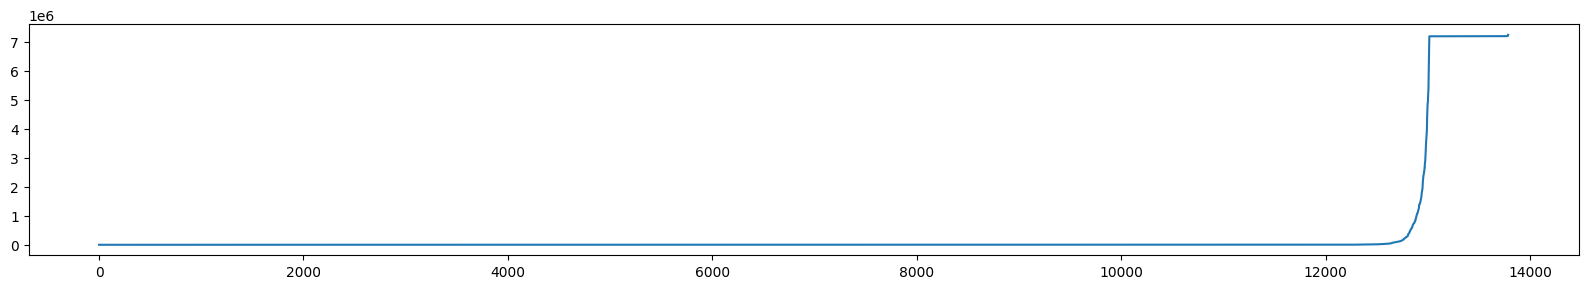

In [222]:
# some dataframe df
all_data['time_to_solution'].sort_values().plot(use_index=False)

<AxesSubplot: >

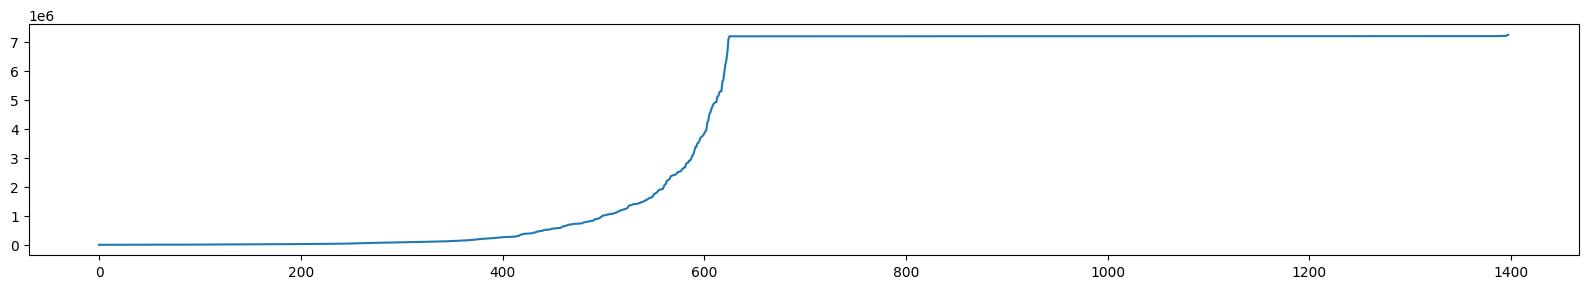

In [223]:
sub_data=all_data[all_data['time_to_solution']>7200]
sub_data['time_to_solution'].sort_values().plot(use_index=False)
#plt.plot(all_data[all_data['time_to_solution']>6000])

In [224]:
#test
#finishes_after_lower_bound.statistics[1]

In [225]:
def cleanup(df):
    del df["decision_level_sat"]
    del df["ewma_decision_level_mip"]
    del df["decision_level_mip"]
#     del df["best_objective"]
#     df["unassnVar"]   = (2**df['vars']) - df['opennodes']
#     df["fracFailUnassn"]     = df['conflicts'] / df['unassnVar']         # num failures/ num open nodes
    df["fracOpenVisit"]  = (df['vars'] - df['opennodes']) / df['opennodes']       # ratio of open nodes to visited nodes (how much of soln space explored)
    df["fracBoolVars"]     = df['boolVars'] / df['vars']                 # num bools / total num of vars
    df["fracPropVars"]     = df['propagations'] / df['vars']        # num propagations/ total num of vars
#     df["frac_unassigned"] = df['unassnVar'] / df['vars']  # current assignments/ total vars
    df["fracLongClauses"] = df['long'] + df['bin'] + df['tern']         # fraction of learnt clauses that have more than 3 literals
    df["freqBackjumps"]  = df['back_jumps']/df['search_time']
    return df

In [226]:
def gradients(df_prev, df_curr):
    keys=['conflicts','ewma_conflicts','decisions','search_iterations','opennodes','ewma_opennodes',
          'vars','back_jumps','ewma_back_jumps','solutions','total_time','search_time','intVars',
          'propagations','sat_propagations','ewma_propagations','propagators','boolVars','learnt',
          'bin','tern','long','peak_depth','decision_level_engine','ewma_decision_level_engine',
          'decision_level_treesize','clause_mem','prop_mem','ewma_best_objective',
          'fracOpenVisit','fracBoolVars','fracPropVars','freqBackjumps', 'best_objective']
    for i in keys:
        df_curr[i+'_gradient']=(df_curr[i]-df_prev[i])/0.05*7200
    return df_curr

In [227]:
features_at_percent = {}

for i in range (1,100):
    df_i=[]
    for id, problem in all_data.iterrows(): 
        for index, p in enumerate(problem.statistics):
            if index == i:
                new_p = dict(p['features'])
                new_p=cleanup(new_p)
                if i!=1:
                    new_p=gradients(df_prev.loc[id], new_p)
                new_p['mzn'] = problem['mzn']
                new_p['dzn'] = problem['dzn']
                new_p['solved_within_time_limit'] = problem['time_to_solution'] < 7199 * 1000 \
                or np.logical_not(np.isnan(problem['time_to_solution']))
                df_i.append((id, new_p))
    df_i = pd.DataFrame([a[1] for a in df_i], index=[a[0] for a in df_i])
    df_i=df_i.fillna(value = 0)
    if i!=0:   
        features_at_percent[i]=df_i
    df_prev=df_i

In [228]:
nans=features_at_percent[20].isna().sum().to_numpy().nonzero()

In [229]:
features_at_percent[20].keys()[nans]

Index([], dtype='object')

In [230]:
features_at_percent[20]
print(len(features_at_percent[20]))

1527


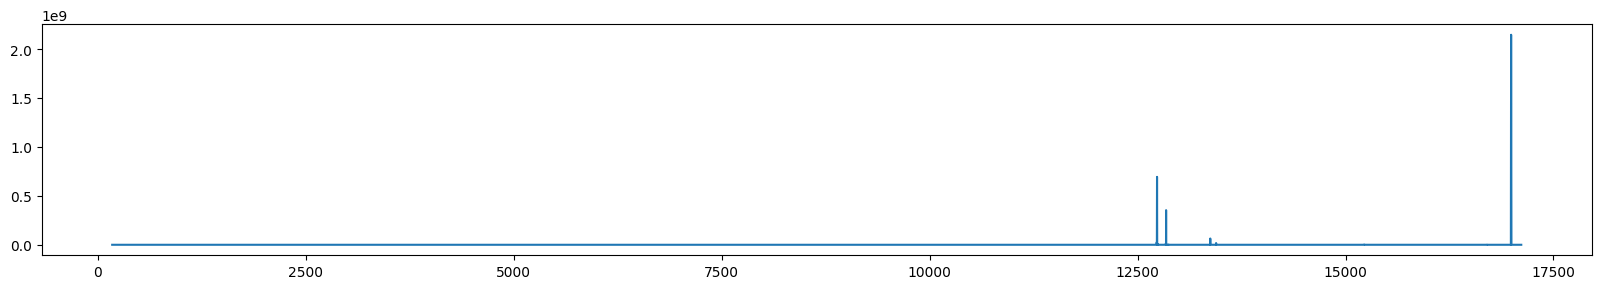

In [231]:
plt.plot(features_at_percent[10]['ewma_best_objective'])

# Data Analysis
## Train Test Split

In [232]:
def preprocessing(df):
    df1=df.drop(['mzn','dzn'], axis=1)
    df1.drop(df1.columns[df1.nunique() == 1], axis=1, inplace=True) #drop cols with constant value
    #rescale data
    transformer = MaxAbsScaler().fit(df1)
    df1 = pd.DataFrame(transformer.transform(df1), columns=df1.columns, index=df1.index) #normalise data
    return df1

In [233]:
df=features_at_percent[20] #THE NUMBER HERE IS THE % OF TL
df=preprocessing(df)
# training-testing split
X_train, X_test, y_train, y_test  = train_test_split(df.drop(columns = ["solved_within_time_limit"]),\
                                                     df["solved_within_time_limit"], test_size=0.25, random_state=22)

In [234]:
y_test.value_counts()

0.0    193
1.0    189
Name: solved_within_time_limit, dtype: int64

In [235]:
y_train.value_counts()

1.0    579
0.0    566
Name: solved_within_time_limit, dtype: int64

## Models

In [236]:
models = {}

# Logistic Regression
from sklearn.linear_model import LogisticRegression
models['LR'] = LogisticRegression(max_iter=1000, C=1000 , class_weight = 'balanced',random_state=22)

#Support Vector Machine
from sklearn.svm import SVC
models['SVM'] = SVC(kernel = 'rbf', class_weight = 'balanced', probability = True, random_state=22)

# Random Forest
from sklearn.ensemble import RandomForestClassifier
models['RF'] = RandomForestClassifier(min_samples_leaf = 5, class_weight = 'balanced_subsample',random_state=22)

#Extra Tree
from sklearn.ensemble import ExtraTreesClassifier
models['ET'] = ExtraTreesClassifier(class_weight = 'balanced', random_state=22)

#Multi-layered perceptron
from sklearn.neural_network import MLPClassifier
models['MLP'] = MLPClassifier(random_state=22)

# Naive Bayes
#from sklearn.naive_bayes import GaussianNB
#models['NB'] = GaussianNB()

# Adaboost
#from sklearn.ensemble import AdaBoostClassifier
#models['AB'] = AdaBoostClassifier()

#KNN
#from sklearn.neighbors import KNeighborsClassifier
#models['KNN'] = KNeighborsClassifier(weights = 'distance')

# Decision Trees
from sklearn.tree import DecisionTreeClassifier
models['DT'] = DecisionTreeClassifier(max_depth = 5, class_weight = 'balanced', random_state=22)

#Dummy classifier
from sklearn.dummy import DummyClassifier
models['DUM'] = DummyClassifier(strategy="most_frequent")

## Predicitions and Evaluation

In [237]:
rf_reg = RandomForestClassifier(min_samples_leaf = 5)
rf_reg.fit(X_train,y_train)

predictions = rf_reg.predict(X_test)
importances = rf_reg.feature_importances_

print('The F1 score with all features of a RandomForestClassifier with min_samples_leaf of 5 is ', f1_score(y_test, predictions))


The F1 score with all features of a RandomForestClassifier with min_samples_leaf of 5 is  0.9177718832891247


## All features

In [238]:
print(X_train.columns)

Index(['conflicts', 'ewma_conflicts', 'decisions', 'search_iterations',
       'opennodes', 'ewma_opennodes', 'vars', 'back_jumps', 'ewma_back_jumps',
       'solutions', 'total_time', 'search_time', 'intVars', 'propagations',
       'sat_propagations', 'ewma_propagations', 'propagators', 'boolVars',
       'learnt', 'bin', 'tern', 'long', 'peak_depth', 'decision_level_engine',
       'ewma_decision_level_engine', 'decision_level_treesize', 'clause_mem',
       'prop_mem', 'best_objective', 'ewma_best_objective', 'fracOpenVisit',
       'fracBoolVars', 'fracPropVars', 'fracLongClauses', 'freqBackjumps',
       'conflicts_gradient', 'ewma_conflicts_gradient', 'decisions_gradient',
       'search_iterations_gradient', 'opennodes_gradient',
       'ewma_opennodes_gradient', 'vars_gradient', 'back_jumps_gradient',
       'ewma_back_jumps_gradient', 'solutions_gradient', 'total_time_gradient',
       'search_time_gradient', 'propagations_gradient',
       'sat_propagations_gradient', 'ewma_

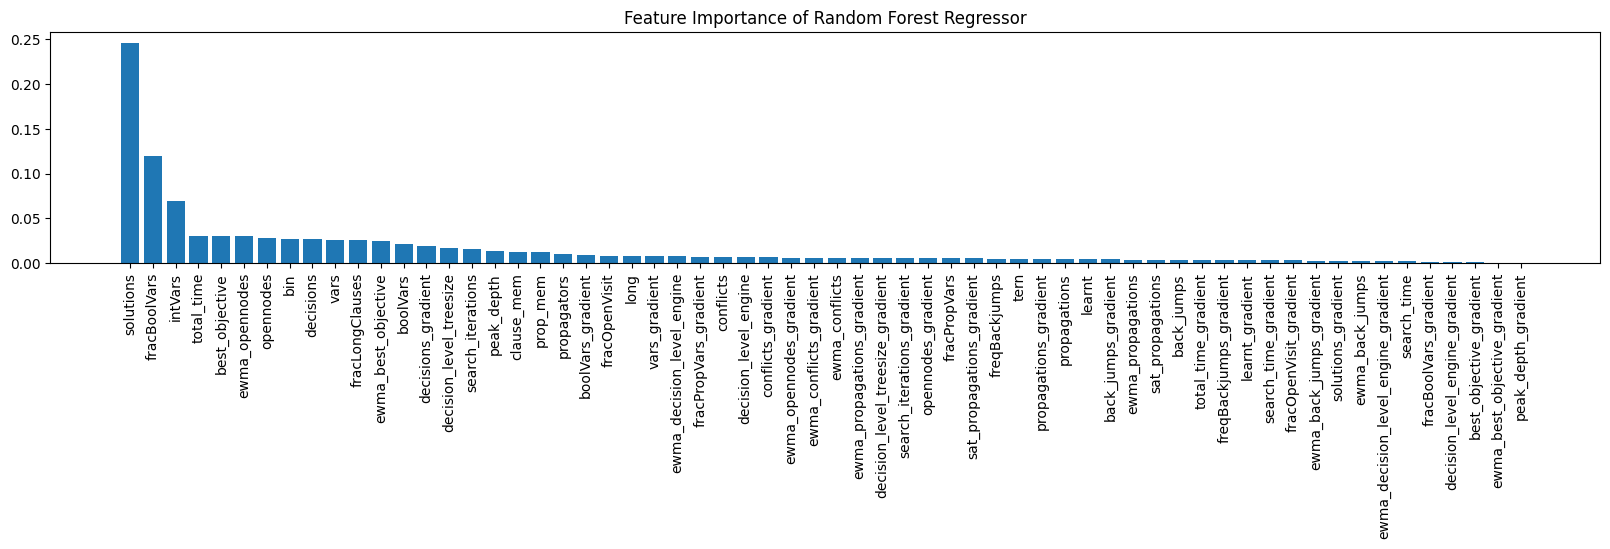

In [239]:

sorted_importance_indices = np.argsort(importances)[::-1]

plt.title('Feature Importance of Random Forest Regressor')
plt.bar(range(len(sorted_importance_indices)), importances[sorted_importance_indices], align='center')
plt.xticks(range(len(sorted_importance_indices)), X_train.columns[sorted_importance_indices], rotation=90)
plt.rcParams["figure.figsize"] = (20,3)
plt.show()

## Top 8 features

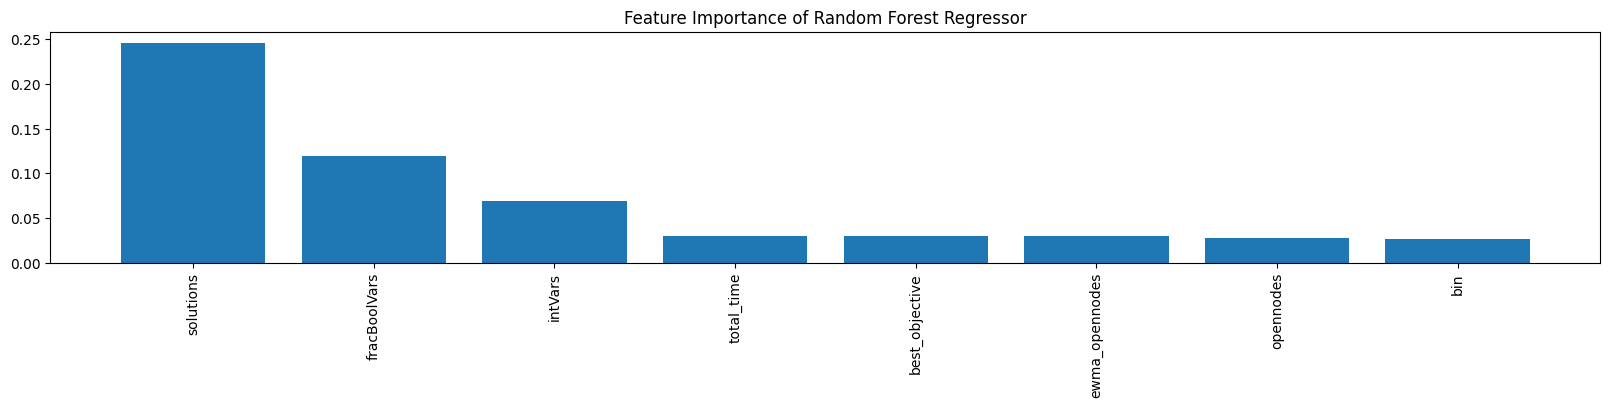

In [240]:


sorted_importance_indices = np.argsort(importances)[::-1][:8]

plt.title('Feature Importance of Random Forest Regressor')
plt.bar(range(8), importances[sorted_importance_indices], align='center')
plt.xticks(range(8), X_train.columns[sorted_importance_indices], rotation=90)
plt.rcParams["figure.figsize"] = (20,3)
plt.show()

In [262]:
sorted_importance_indices = np.argsort(importances)[::-1][:8]

def f1_with_n_top_features(n, importance_column_indices):
    summed = 0
    for i in range(0, 10):
        X_train, X_test, y_train, y_test  = train_test_split(df.drop(columns = ["solved_within_time_limit"]),\
                                                     df["solved_within_time_limit"], test_size=0.25)
        rf_reg = RandomForestClassifier(min_samples_leaf = 5)
        rf_reg.fit(X_train.iloc[:, importance_column_indices[:n]], y_train)

        predictions = rf_reg.predict(X_test.iloc[:, importance_column_indices[:n]])
        summed += f1_score(y_test, predictions)
    return summed / 10



f1_scores = [(i, f1_with_n_top_features(i, sorted_importance_indices)) for i in range(1, len(sorted_importance_indices) + 1)[::-1]]

plt.title(f'F1 score for top N features ({"OPTIMIZATION" if data_types_to_consider is InstanceType.OPTIMIZATION else "SAT"})')
plt.bar([a[0] for a in f1_scores], [a[1] for a in f1_scores], align='center')
plt.xticks(range(len(f1_scores)), [a[0] for a in f1_scores], rotation=90)
plt.rcParams["figure.figsize"] = (20,3)
plt.show()



NameError: name 'X_trainsorted_importance_indices' is not defined

In [242]:
def results_plt(X_train, y_train, X_test, y_test, perc_TL):
    train_accuracy, accuracy, precision, recall, auc, f1 = {}, {}, {}, {}, {}, {}
    figs, axs = plt.subplots(2,3,figsize=(20, 12))

    for i, key in enumerate(models.keys()):

        # Fit the classifier model
        models[key].fit(X_train, y_train)

        predictions = models[key].predict(X_test)
        predictions_prob = models[key].predict_proba(X_test)[:,1]
        train_predictions = models[key].predict(X_train)
        # Predic  
        # Calculate Accuracy, Precision and Recall Metrics
        accuracy[key] = accuracy_score(predictions, y_test)
        precision[key] = precision_score(predictions, y_test, zero_division=1)
        recall[key] = recall_score(predictions, y_test, zero_division=1)
        auc[key] = roc_auc_score(y_test, predictions_prob)
        train_accuracy[key] = accuracy_score(train_predictions, y_train)
        f1[key] = f1_score(y_test,predictions)
        #should it be (true, pred)? yes

        #To Display
        RocCurveDisplay.from_predictions(y_test, predictions_prob, name=key , ax=axs[0,0])
        axs[0,1].bar(key, accuracy[key]) 
        axs[0,2].bar(key, train_accuracy[key]) 
        axs[1,0].bar(key, recall[key])
        axs[1,1].bar(key, precision[key])
        axs[1,2].bar(key, f1[key])

        axs[0,0].set_title("ROC Curve for "+perc_TL+"% TL")
        #axs[0].set_ylabel("Accuracy")

        axs[0,1].set_title("Test Accuracy for "+perc_TL+"% TL")
        axs[0,1].set_xticklabels(models.keys(),rotation=60)
        axs[0,1].set_ylabel("Accuracy")
        axs[0,1].grid(axis='y', color='gray', linestyle='dashed')

        axs[0,2].set_title("Train Accuracy for "+perc_TL+"% TL")
        axs[0,2].set_xticklabels(models.keys(),rotation=60)
        axs[0,2].set_ylabel("Accuracy")
        axs[0,2].grid(axis='y', color='gray', linestyle='dashed')

        axs[1,0].set_title("Recall for "+perc_TL+"% TL")
        axs[1,0].set_xticklabels(models.keys(),rotation=60)
        axs[1,0].set_ylabel("Recall")
        axs[1,0].grid(axis='y', color='gray', linestyle='dashed')


        axs[1,1].set_title("Precision "+perc_TL+"% TL")
        axs[1,1].set_xticklabels(models.keys(),rotation=60)
        axs[1,1].set_ylabel("F1")
        axs[1,1].grid(axis='y', color='gray', linestyle='dashed')

        axs[1,2].set_title("F1 "+perc_TL+"% TL")
        axs[1,2].set_xticklabels(models.keys(),rotation=60)
        axs[1,2].set_ylabel("F1")
        axs[1,2].grid(axis='y', color='gray', linestyle='dashed')
        figs.show()   


/home/alexander/Documents/TUDelft/idmp-b/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/tmp/ipykernel_33451/1482028916.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0,1].set_xticklabels(models.keys(),rotation=60)
/tmp/ipykernel_33451/1482028916.py:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0,2].set_xticklabels(models.keys(),rotation=60)
/tmp/ipykernel_33451/1482028916.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax

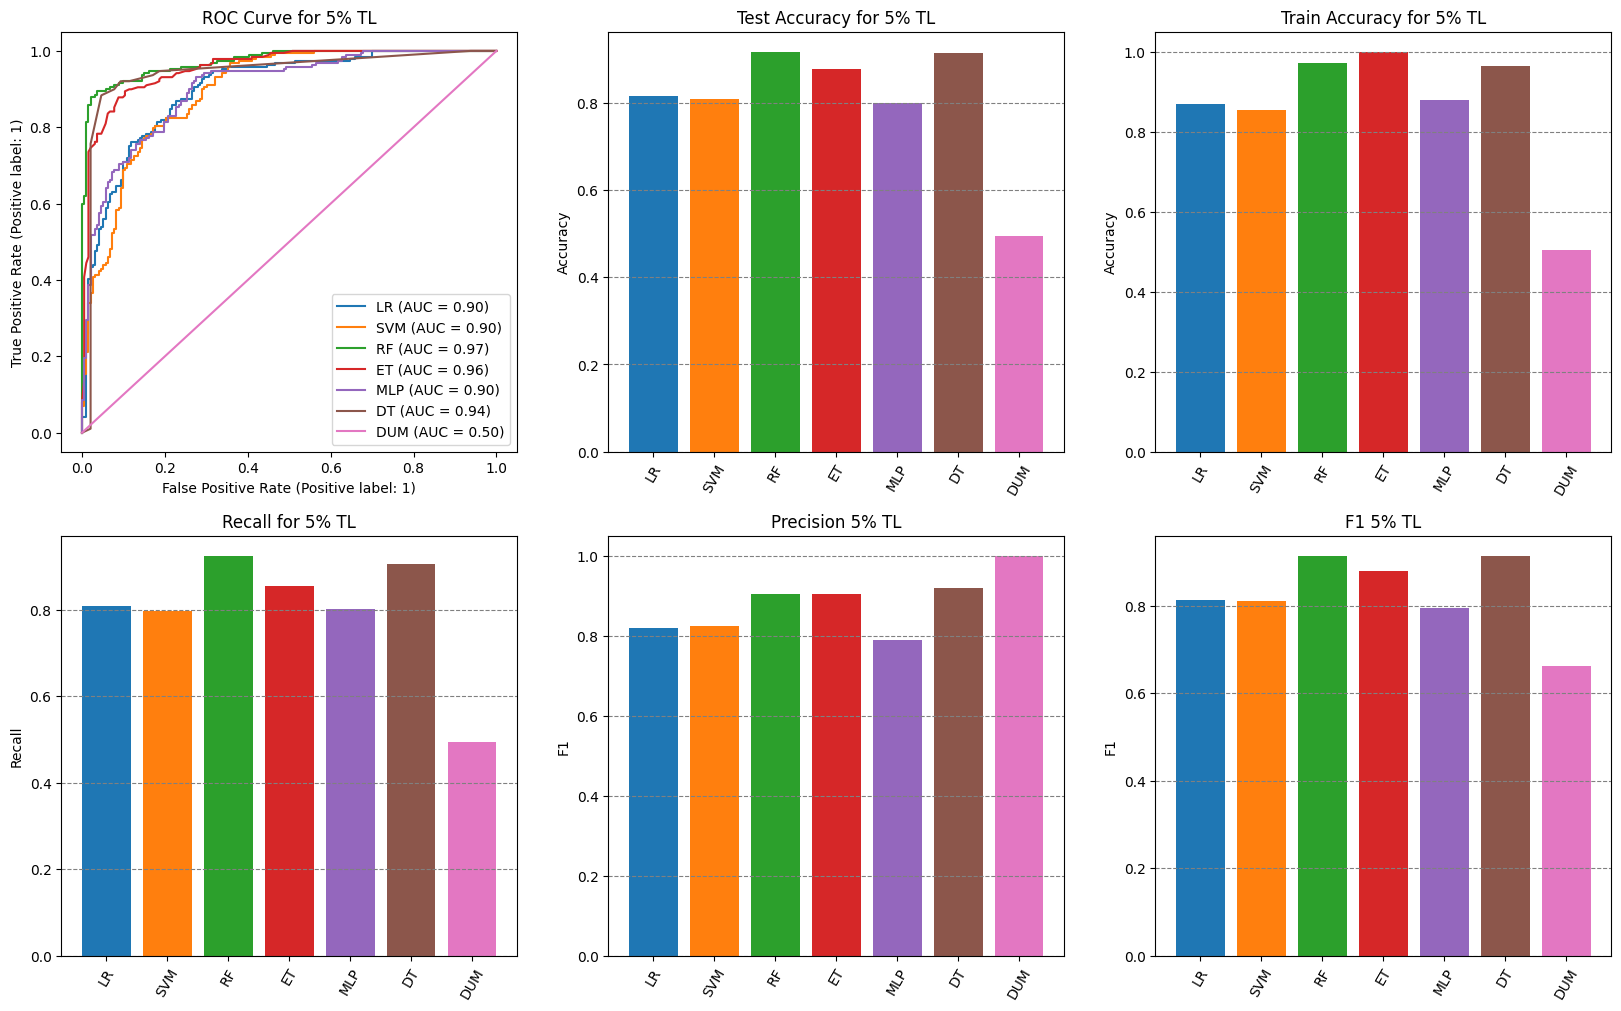

In [243]:
#Bar plot results  for testing and training using top 5 created features

results_plt(X_train, y_train, X_test, y_test, "5")

## Regression

In [244]:
all_data_reg = all_data[all_data.time_to_solution <  7199* 1000] #<2h

In [245]:
all_data_reg

,_id,mzn,dzn,generated_features,generated_label,claimed_features_generation,claimed_label_generation,type,time_to_solution,time_limit,solved,statistics,problem_type,error,was_error
0,63481481fdd73d481158ca82,mrcpsp/mrcpsp.mzn,mrcpsp/data/m4_26_1.dzn,True,True,True,True,OPT,91.0,72000000.0,True,"[{'percent': 6.666666666666667e-12, 'features'...",OPT,NaN,NaN
1,63481481fdd73d481158ca83,mrcpsp/mrcpsp.mzn,mrcpsp/data/n1_57_8.dzn,True,True,True,True,OPT,120.0,72000000.0,True,"[{'percent': 1.2222222222222223e-11, 'features...",OPT,NaN,NaN
2,63481481fdd73d481158ca84,mrcpsp/mrcpsp.mzn,mrcpsp/data/j14_23_1.dzn,True,True,True,True,OPT,83.0,72000000.0,True,"[{'percent': 3.4722222222222225e-12, 'features...",OPT,NaN,NaN
3,63481481fdd73d481158ca85,mrcpsp/mrcpsp.mzn,mrcpsp/data/r1_33_7.dzn,True,True,True,True,OPT,102.0,72000000.0,True,"[{'percent': 5.4166666666666665e-12, 'features...",OPT,NaN,NaN
4,63481481fdd73d481158ca86,mrcpsp/mrcpsp.mzn,mrcpsp/data/j12_12_4.dzn,True,True,True,True,OPT,72.0,72000000.0,True,"[{'percent': 5.972222222222222e-12, 'features'...",OPT,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17102,63481489fdd73d481159045e,2DBinPacking/2DLevelPacking.mzn,2DBinPacking/data/Class9_40_1.dzn,True,True,True,True,OPT,193.0,72000000.0,True,"[{'percent': 1.5402777777777778e-10, 'features...",OPT,NaN,NaN
17106,63481489fdd73d4811590462,2DBinPacking/2DLevelPacking.mzn,2DBinPacking/data/Class8_20_3.dzn,True,True,True,True,OPT,161.0,72000000.0,True,"[{'percent': 9.236111111111111e-11, 'features'...",OPT,NaN,NaN
17109,63481489fdd73d4811590465,2DBinPacking/2DLevelPacking.mzn,2DBinPacking/data/Class9_80_4.dzn,True,True,True,True,OPT,1411685.0,72000000.0,True,"[{'percent': 3.363888888888889e-10, 'features'...",OPT,NaN,NaN
17110,63481489fdd73d4811590466,2DBinPacking/2DLevelPacking.mzn,2DBinPacking/data/Class4_20_4.dzn,True,True,True,True,OPT,17042.0,72000000.0,True,"[{'percent': 1.636111111111111e-10, 'features'...",OPT,NaN,NaN


In [246]:
features_at_percent_reg = {}
for i in range (1,100):
    df_i_reg=[]
    for id, problem in all_data_reg.iterrows():
            for index, p in enumerate(problem.statistics):
                if index == i:
                    new_p = dict(p['features'])
                    new_p=cleanup(new_p)
                    if i!=1:
                        new_p=gradients(df_prev.loc[id], new_p)
                    new_p['mzn'] = problem['mzn']
                    new_p['dzn'] = problem['dzn']
                    new_p['time_to_solution'] = problem['time_to_solution']
                    df_i_reg.append((id, new_p))
    df_i_reg = pd.DataFrame([a[1] for a in df_i_reg], index=[a[0] for a in df_i_reg])
    df_i_reg=df_i_reg.fillna(value = 0)
    if i!=0:   
        features_at_percent_reg[i]=df_i_reg
    df_prev=df_i_reg

In [247]:
features_at_percent[5]

,conflicts,ewma_conflicts,decisions,search_iterations,opennodes,ewma_opennodes,vars,back_jumps,ewma_back_jumps,solutions,...,prop_mem_gradient,ewma_best_objective_gradient,fracOpenVisit_gradient,fracBoolVars_gradient,fracPropVars_gradient,freqBackjumps_gradient,best_objective_gradient,mzn,dzn,solved_within_time_limit
57,247813,247794.0,273950,521764,24807,24806.41,24816,26126,0.11,0,...,0.0,0.0,11.612902,0.000000,6.183166e+07,1.430751e+06,0.0,mrcpsp/mrcpsp.mzn,mrcpsp/data/j30_5_3.dzn,False
73,227704,227685.0,351781,579486,24980,24978.87,24985,124070,0.94,0,...,0.0,0.0,-23.066756,0.000000,2.521424e+07,5.133365e+06,0.0,mrcpsp/mrcpsp.mzn,mrcpsp/data/j30_4_8.dzn,False
144,266616,266597.0,283643,550260,26336,26336.53,26347,17015,0.13,0,...,0.0,0.0,-10.941000,0.000000,3.342495e+08,-1.201245e+06,0.0,mrcpsp/mrcpsp.mzn,mrcpsp/data/j30_5_6.dzn,False
172,224415,224396.0,297440,353947,25040,25039.47,25069,72333,0.05,14,...,0.0,0.0,5.757229,0.000000,1.276997e+08,2.585377e+06,0.0,mrcpsp/mrcpsp.mzn,mrcpsp/data/j30_53_6.dzn,True
272,328204,328185.0,341922,670127,23683,23684.73,23693,13707,0.04,0,...,0.0,0.0,12.164729,0.000000,3.783369e+07,-4.533740e+05,0.0,mrcpsp/mrcpsp.mzn,mrcpsp/data/j30_6_4.dzn,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17108,84514,84495.0,158283,242798,26128,26129.54,26226,73669,0.64,0,...,0.0,0.0,110.555385,0.000000,2.388310e+06,-1.056328e+07,0.0,2DBinPacking/2DLevelPacking.mzn,2DBinPacking/data/Class4_80_8.dzn,False
17109,199579,199560.0,212342,411922,31098,31098.73,31118,12742,0.00,0,...,0.0,0.0,-50.986545,0.000000,6.760262e+07,4.176274e+05,0.0,2DBinPacking/2DLevelPacking.mzn,2DBinPacking/data/Class9_80_4.dzn,True
17110,319803,319784.0,329768,649572,1737,1735.65,1763,9939,0.00,0,...,0.0,0.0,-168.478894,0.000000,9.041860e+07,-3.577863e+05,0.0,2DBinPacking/2DLevelPacking.mzn,2DBinPacking/data/Class4_20_4.dzn,True
17112,49001,48982.0,49900,98902,46337,46337.15,46342,892,0.00,0,...,0.0,0.0,-6.216274,0.000000,7.299963e+07,1.095475e+04,0.0,2DBinPacking/2DLevelPacking.mzn,2DBinPacking/data/Class5_100_8.dzn,False


In [248]:
grid=[5,10,20,50,90]
for i in grid:
    print("At",i,"%:")
    print(len(features_at_percent[i].index))
    print(len(features_at_percent_reg[i].index))
    

At 5 %:
2183
405
At 10 %:
2035
320
At 20 %:
1527
178
At 50 %:
391
18
At 90 %:
159
4


In [249]:
df_reg=features_at_percent_reg[1] #THE NUMBER HERE IS THE % OF TL
df_reg=preprocessing(df_reg)
# training-testing split
X_train_reg, X_test_reg, y_train_reg, y_test_reg  = train_test_split(df_reg.drop(columns = ["time_to_solution"]),\
                                                     df_reg["time_to_solution"], test_size=0.25, random_state=22)

In [250]:
#RANDOM FOREST
from sklearn.ensemble import RandomForestRegressor
regr = RandomForestRegressor(max_depth=1000000000000)
regr.fit(X_train_reg, y_train_reg)
predictions=regr.predict(X_test_reg)
sk_score = regr.score(X_test_reg, y_test_reg)
sk_score

0.10425898460935457

In [251]:
#SUPPORT VECTOR MACHINE
from sklearn import svm
regr = svm.SVR()
regr.fit(X_train_reg, y_train_reg)
predictions=regr.predict(X_test_reg)
sk_score = regr.score(X_test_reg, y_test_reg)
sk_score

0.035217803244067314

In [252]:
#RIDGE
from sklearn.linear_model import Ridge
clf = Ridge(alpha=1.0)
clf.fit(X_train_reg, y_train_reg)
predictions=clf.predict(X_test_reg)
sk_score = clf.score(X_test_reg, y_test_reg)
sk_score

0.0462704169337097

In [253]:
#LASSO
from sklearn import linear_model
clf = linear_model.Lasso(alpha=0.1)
clf.fit(X_train_reg, y_train_reg)
predictions=clf.predict(X_test_reg)
sk_score = clf.score(X_test_reg, y_test_reg)
sk_score

-0.005286966128905002

In [254]:
#ELASTICNET
from sklearn.linear_model import ElasticNet
regr = ElasticNet()
regr.fit(X_train_reg, y_train_reg)
predictions=regr.predict(X_test_reg)
sk_score = regr.score(X_test_reg, y_test_reg)
sk_score

-0.005286966128905002

In [255]:
#TREE
from sklearn import tree
clf = tree.DecisionTreeRegressor(max_depth=5)
clf.fit(X_train_reg, y_train_reg)
predictions=clf.predict(X_test_reg)
sk_score = clf.score(X_test_reg, y_test_reg)
sk_score

-0.09961994604408653

In [256]:
#PLS
from sklearn.cross_decomposition import PLSRegression
pls2 = PLSRegression(n_components=2)
pls2.fit(X_train_reg, y_train_reg)
predictions=pls2.predict(X_test_reg)
sk_score = pls2.score(X_test_reg, y_test_reg)
sk_score

0.043497692609546945

In [257]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
kernel = DotProduct() + WhiteKernel()
gpr = GaussianProcessRegressor(kernel=kernel).fit(X_train_reg, y_train_reg)
predictions=gpr.predict(X_test_reg)
sk_score = gpr.score(X_test_reg, y_test_reg)
sk_score

0.04541452297766002

# Ignore the rest! 
# -- -- -- -- -- -- 
# -- -- -- -- -- -- 
# -- -- -- -- -- -- 
# -- -- -- -- -- -- 
# -- -- -- -- -- -- 
# -- -- -- -- -- -- 

# **Feature Importance Analysis**

Feature importance for all features

Large error bars may result from Gini Importance being misleading when features have many unique values 



UnboundLocalError: local variable 'c_array' referenced before assignment

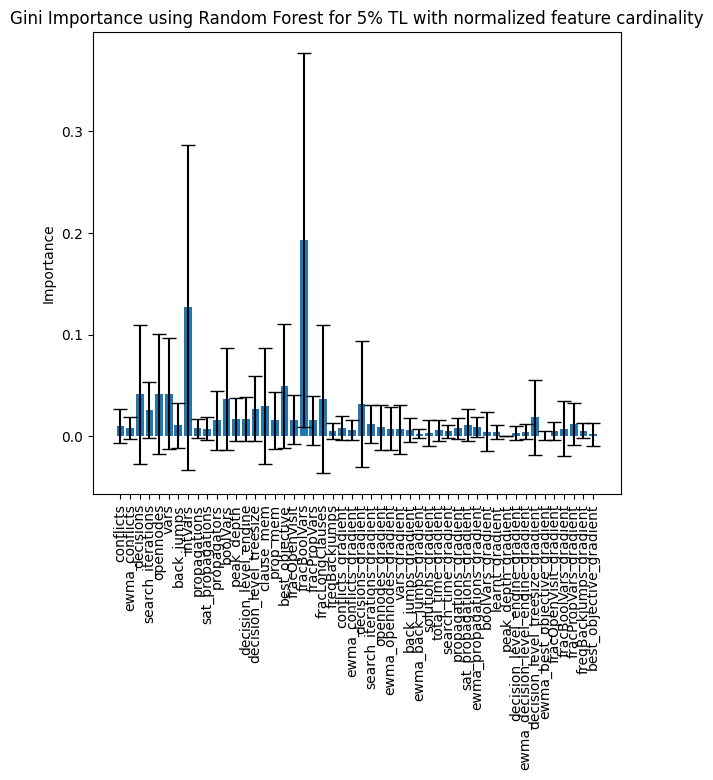

In [258]:
def feat_import_plt(X, y, perc_TL):
    #Display Flags 
    ordered = False   #True displays importances in descending order
    errorbar = True
    cardinality = False
    
    #Drop values that are neither standard chuffed values nor created
    X = X.drop(["solutions",
                "total_time",
                "search_time", #total time - init time
                "learnt" ,
                "bin",
                "tern",
                "long",
                "ewma_opennodes",
                "ewma_decision_level_engine",
                "ewma_back_jumps",
                "ewma_propagations",
                "ewma_best_objective"], axis=1, inplace=False)

    #Feature importance using Gini Impurity
    dcs_t = RandomForestClassifier(min_samples_leaf = 5,random_state=22)
    dcs_t.fit(X, y)
    
    importances = dcs_t.feature_importances_
    std = np.std([tree.feature_importances_ for tree in dcs_t.estimators_], axis=0) #get standard dev of importances
    
    if ordered:
        _sorted_indices = np.argsort(importances)[::-1]   # Sort the feature importance in descending order
    else:
        _sorted_indices = np.array(range(len(importances)))   # unsorted feature importances for comparison

    plt.figure(figsize=(15, 6))
    ax1 = plt.subplot(1, 2, 1)
    plt.title('Gini Importance using Random Forest for '+ perc_TL+'% TL with normalized feature cardinality')
    
    if not errorbar:
        ax1.bar(range(X.shape[1]), importances[_sorted_indices])
    else :
        ax1.bar(range(X.shape[1]), importances[_sorted_indices], yerr=std, ecolor='black', capsize=5, align='center')
        ax1.set_ylabel('Importance')
        plt.xticks(range(X.shape[1]), X.columns[_sorted_indices], rotation=90)

    #print("GI:", importances[sorted_indices])

    if cardinality:
        c = df_5.apply(pd.Series.nunique) #feature cardinalityc_array = []
    for i in X.columns[_sorted_indices]:
        c_array.append(c.loc[i]/ max(df_5.apply(pd.Series.nunique).values))
    
    ax2 = ax1.twinx()
    ax2.plot(range(X.shape[1]), c_array, color = 'r' )
    ax2.set_ylabel('Cardinality', color = 'r')

    #Feature importance using Permutation Importance
    perm = permutation_importance(dcs_t, X, y, random_state = 22)
    if ordered:
        _perm_sorted_indices = np.argsort(perm.importances_mean)[::-1] # Sort the feature importance in descending order
    else:
        _perm_sorted_indices = _sorted_indices

    ax3 = plt.subplot(1, 2, 2)
    plt.title('Permutation Importance using Random Forest for '+ perc_TL+'% TL')
    if not errorbar:
        ax3.bar(range(X.shape[1]), perm.importances_mean[_perm_sorted_indices]*10)
    else:
        ax3.bar(range(X.shape[1]), perm.importances_mean[_perm_sorted_indices]*10, yerr=perm.importances_std, ecolor='black', capsize=5, align='center')
    plt.xticks(range(X.shape[1]), X.columns[_perm_sorted_indices], rotation=90)
    ax3.set_ylabel('Importance')

    #print("PI:", perm.importances_mean[perm_sorted_indices])

    if cardinality:
        c_array = []
        for i in X.columns[_perm_sorted_indices]:
            c_array.append(c.loc[i]/ max(df_5.apply(pd.Series.nunique).values))
        ax2 = ax3.twinx()
        ax2.plot(range(X.shape[1]), c_array, color = 'r' )
        ax2.set_ylabel('Cardinality', color = 'r')

    #plt.subplot(1, 3, 3)
    #sns.heatmap(X.corr(), mask = np.triu(X.corr()) )


    plt.tight_layout()
    plt.show()

print("Large error bars may result from Gini Importance being misleading when features have many unique values \n")
feat_import_plt(X_train, y_train,  "5")
# feat_import_plt(X_train_10, y_train_10, "10")
# feat_import_plt(X_train_15, y_train_15,  "15")
# feat_import_plt(X_train_20, y_train_20,  "20")

Feature importance for proposed (or created) features

In [ ]:
#Only keep proposed features
for df in df_list:
    df.drop(["opennodes",
             "ewma_opennodes",
             "ewma_decision_level_engine",
             "vars",
             "back_jumps",
             "ewma_back_jumps",
             "solutions",
             "total_time",
             "search_time", #total time - init time
             "intVars",
             "propagations",
             "ewma_propagations",
             "propagators",
             "boolVars",
             "learnt" ,
             "bin",
             "tern",
             "long",
             "peak_depth",
             "best_objective",
             "ewma_best_objective"], axis=1, inplace=True)
  
  
  
#dummy vars for df_5 to match size of other dfs
df_5["objectiveGROC"] = np.zeros(df_5.shape[0])
df_5["failuresGROC"] = np.zeros(df_5.shape[0])
df_5["backjumpsGROC"] = np.zeros(df_5.shape[0])
df_5["propagationsGROC"] = np.zeros(df_5.shape[0])
df_5["solutionsGROC"] = np.zeros(df_5.shape[0])


# Resplit dats into training-testing 
Xd_train_5, Xd_test_5, yd_train_5, yd_test_5  = train_test_split(df_5.drop(columns = ["solved_within_time_limit"]),\
                                                     df_5["solved_within_time_limit"], test_size=0.25, random_state=22)

# Xd_train_10, Xd_test_10, yd_train_10, yd_test_10  = train_test_split(df_10.drop(columns = ["solved_within_time_limit"]),\
#                                                      df_10["solved_within_time_limit"], test_size=0.25, random_state=22)

# Xd_train_15, Xd_test_15, yd_train_15, yd_test_15  = train_test_split(df_15.drop(columns = ["solved_within_time_limit"]),\
#                                                      df_15["solved_within_time_limit"], test_size=0.25, random_state=22)

# Xd_train_20, Xd_test_20, yd_train_20, yd_test_20  = train_test_split(df_20.drop(columns = ["solved_within_time_limit"]),\
#                                                      df_20["solved_within_time_limit"], test_size=0.25, random_state=22)
# #Feature importances using only proposed features
def importance (X, y):
  dcs_5 = RandomForestClassifier(min_samples_leaf = 5,random_state=22)
  dcs_5.fit(X, y)
  importances_5 = dcs_5.feature_importances_
  std_5 = np.std([tree.feature_importances_ for tree in dcs_5.estimators_], axis=0) #get standard dev of importances
  perm_5 = permutation_importance(dcs_5, X, y, random_state = 22)
  return importances_5, perm_5

[importances_5, perm_5] = importance(Xd_train_5, yd_train_5)
sorted_indices = np.argsort(importances_5)[::-1] 
perm_sorted_indices = np.argsort(perm_5.importances_mean)[::-1] 

# [importances_10, perm_10] = importance(Xd_train_10, yd_train_10)
# sorted_indices_10 = np.argsort(importances_10)[::-1] 
# perm_sorted_indices_10 = np.argsort(perm_10.importances_mean)[::-1]

# [importances_15, perm_15] = importance(Xd_train_15, yd_train_15)
# sorted_indices_15 = np.argsort(importances_15)[::-1] 
# perm_sorted_indices_15 = np.argsort(perm_15.importances_mean)[::-1] 

# [importances_20, perm_20] = importance(Xd_train_20, yd_train_20)
# sorted_indices_20 = np.argsort(importances_20)[::-1] 
# perm_sorted_indices_20 = np.argsort(perm_20.importances_mean)[::-1] 

#Print images
printAll = True #set to flase to show top 10 features

if printAll:
  plt.figure(figsize=(7, 5))
  plt.title('Gini Importance of Created Features for Varying % TL')
  plt.plot(Xd_train_5.columns[sorted_indices][0:9], importances_5[sorted_indices][0:9],'-o' )
#   plt.plot(Xd_train_10.columns[sorted_indices], importances_10[sorted_indices], '-s')
#   plt.plot(Xd_train_15.columns[sorted_indices], importances_15[sorted_indices], '-^' )
#   plt.plot(Xd_train_20.columns[sorted_indices], importances_20[sorted_indices], '-v')
  plt.axhline(y=0.10, linestyle='--')
  plt.xticks(range(Xd_train_5.shape[1]), Xd_train_5.columns[sorted_indices], rotation=90)
  plt.ylabel('Importance')
  plt.grid(axis='both', color='gray', linestyle='dashed')
  plt.legend(["5% TL", "10% TL", "15% TL", "20% TL"])

  plt.figure(figsize=(7, 5))
  plt.title('Permutation Importance of Created Features for Varying % TL')
  plt.plot(Xd_train_5.columns[sorted_indices][0:9], perm_5.importances_mean[sorted_indices][0:9]*10,'-o' )
#   plt.plot(Xd_train_10.columns[sorted_indices], perm_10.importances_mean[sorted_indices]*10, '-s')
#   plt.plot(Xd_train_15.columns[sorted_indices], perm_15.importances_mean[sorted_indices]*10, '-^' )
#   plt.plot(Xd_train_20.columns[sorted_indices], perm_20.importances_mean[sorted_indices]*10, '-v')
  plt.axhline(y=0.07, linestyle='--')
  plt.xticks(range(Xd_train_5.shape[1]), Xd_train_5.columns[sorted_indices], rotation=90)
  plt.ylabel('Importance')
  plt.grid(axis='both', color='gray', linestyle='dashed')
  plt.legend(["5% TL", "10% TL", "15% TL", "20% TL"])
else:
  plt.figure(figsize=(7, 5))
  plt.title('Top 10 Gini Important Created Features for Varying % TL')
  plt.plot(Xd_train_5.columns[sorted_indices][0:10], importances_5[sorted_indices][0:10],'o' )
  plt.plot(Xd_train_10.columns[sorted_indices_10][0:10], importances_10[sorted_indices_10][0:10], 's')
  plt.plot(Xd_train_15.columns[sorted_indices_15][0:10], importances_15[sorted_indices_15][0:10], '^' )
  plt.plot(Xd_train_20.columns[sorted_indices_20][0:10], importances_20[sorted_indices_20][0:10], 'v')
  plt.axhline(y=0.10, linestyle='--')
  plt.xticks(range(13), Xd_train_5.columns[sorted_indices][0:12], rotation=90)
  plt.ylabel('Importance')
  plt.grid(axis='both', color='gray', linestyle='dashed')
  plt.legend(["5% TL", "10% TL", "15% TL", "20% TL"])

  plt.figure(figsize=(7, 5))
  plt.title('Top 10 Permutation Important Created Features for Varying % TL')
  plt.plot(Xd_train_5.columns[perm_sorted_indices][0:10], perm_5.importances_mean[perm_sorted_indices][0:10]*10,'o' )
  plt.plot(Xd_train_10.columns[perm_sorted_indices_10][0:10], perm_10.importances_mean[perm_sorted_indices_10][0:10]*10, 's')
  plt.plot(Xd_train_15.columns[perm_sorted_indices_15][0:10], perm_15.importances_mean[perm_sorted_indices_15][0:10]*10, '^' )
  plt.plot(Xd_train_20.columns[perm_sorted_indices_20][0:10], perm_20.importances_mean[perm_sorted_indices_20][0:10]*10, 'v')
  plt.axhline(y=0.07, linestyle='--')
  plt.xticks(range(13), Xd_train_5.columns[perm_sorted_indices][0:12], rotation=90)
  plt.ylabel('Importance')
  plt.grid(axis='both', color='gray', linestyle='dashed')
  plt.legend(["5% TL", "10% TL", "15% TL", "20% TL"])


In [ ]:
#select top 5 features for training
Xs_train_5  = Xd_train_5.iloc[:, sorted_indices[0:5]]
# Xs_train_10 = Xd_train_10.iloc[:,sorted_indices_10[0:5]]
# Xs_train_15 = Xd_train_15.iloc[:,sorted_indices_15[0:5]]
# Xs_train_20 = Xd_train_20.iloc[:,sorted_indices_20[0:5]]

Xs_test_5  = Xd_test_5.iloc[:,sorted_indices[0:5]]
# Xs_test_10 = Xd_test_10.iloc[:,sorted_indices_10[0:5]]
# Xs_test_15 = Xd_test_15.iloc[:,sorted_indices_15[0:5]]
# Xs_test_20 = Xd_test_20.iloc[:,sorted_indices_20[0:5]]

print("Top 5 features:",Xd_train_5.columns[sorted_indices][0:5])

# **Predictions and Evaluation**

In [ ]:
def results_plt(X_train, y_train, X_test, y_test, perc_TL):
    train_accuracy, accuracy, precision, recall, auc, f1 = {}, {}, {}, {}, {}, {}
    figs, axs = plt.subplots(1,6,figsize=(35, 5))

    for i, key in enumerate(models.keys()):

        # Fit the classifier model
        models[key].fit(X_train, y_train)

        predictions = models[key].predict(X_test)
        predictions_prob = models[key].predict_proba(X_test)[:,1]
        train_predictions = models[key].predict(X_train)
        # Predic  
        # Calculate Accuracy, Precision and Recall Metrics
        accuracy[key] = accuracy_score(predictions, y_test)
        precision[key] = precision_score(predictions, y_test, zero_division=1)
        recall[key] = recall_score(predictions, y_test, zero_division=1)
        auc[key] = roc_auc_score(y_test, predictions_prob)
        train_accuracy[key] = accuracy_score(train_predictions, y_train)
        f1[key] = f1_score(y_test,predictions)
        #should it be (true, pred)? yes

        #To Display
        RocCurveDisplay.from_predictions(y_test, predictions_prob, name=key , ax=axs[0])
        axs[1].bar(key, accuracy[key]) 
        axs[2].bar(key, train_accuracy[key]) 
        axs[3].bar(key, recall[key])
        axs[4].bar(key, precision[key])
        axs[5].bar(key, f1[key])

        axs[0].set_title("ROC Curve for "+perc_TL+"% TL")
        #axs[0].set_ylabel("Accuracy")

        axs[1].set_title("Test Accuracy for "+perc_TL+"% TL")
        axs[1].set_xticklabels(models.keys(),rotation=60)
        axs[1].set_ylabel("Accuracy")
        axs[1].grid(axis='y', color='gray', linestyle='dashed')

        axs[2].set_title("Train Accuracy for "+perc_TL+"% TL")
        axs[2].set_xticklabels(models.keys(),rotation=60)
        axs[2].set_ylabel("Accuracy")
        axs[2].grid(axis='y', color='gray', linestyle='dashed')

        axs[3].set_title("Recall for "+perc_TL+"% TL")
        axs[3].set_xticklabels(models.keys(),rotation=60)
        axs[3].set_ylabel("Recall")
        axs[3].grid(axis='y', color='gray', linestyle='dashed')


        axs[4].set_title("Precision "+perc_TL+"% TL")
        axs[4].set_xticklabels(models.keys(),rotation=60)
        axs[4].set_ylabel("F1")
        axs[4].grid(axis='y', color='gray', linestyle='dashed')

        axs[5].set_title("F1 "+perc_TL+"% TL")
        axs[5].set_xticklabels(models.keys(),rotation=60)
        axs[5].set_ylabel("F1")
        axs[5].grid(axis='y', color='gray', linestyle='dashed')
        figs.show()   

In [ ]:
#Bar plot results  for testing and training using top 5 created features
results_plt(X_train, y_train, X_test, y_test, "40")

In [ ]:
def results_line_plt(X_train, y_train, X_test, y_test, perc_TL):
  train_accuracy, accuracy, precision, recall, auc, f1 = {}, {}, {}, {}, {}, {}
  #figs, axs = plt.subplots(1,6,figsize=(35, 5))

  for i, key in enumerate(models.keys()):

          # Fit the classifier model
          models[key].fit(X_train, y_train)

          # Prediction
          predictions = models[key].predict(X_test)
          predictions_prob = models[key].predict_proba(X_test)[:,1]
          train_predictions = models[key].predict(X_train)

          # Calculate Accuracy, Precision and Recall Metrics
          accuracy[key] = accuracy_score(predictions, y_test)
          precision[key] = precision_score(predictions, y_test, zero_division=1)
          recall[key] = recall_score(predictions, y_test, zero_division=1)
          auc[key] = roc_auc_score(y_test, predictions_prob)
          train_accuracy[key] = accuracy_score(train_predictions, y_train)
          f1[key] = f1_score(y_test,predictions)
          #should it be (true, pred)? yes
  print("\n------------------------------------------------------------------------")
  print(perc_TL+"% TL train acc:", np.round(list(train_accuracy.values()),2))
  print(perc_TL+"% TL test acc :", np.round(list(accuracy.values()),2))
  print(perc_TL+"% TL precision:",  np.round(list(precision.values()),2))
  print(perc_TL+"% TL recall   :",  np.round(list(recall.values()),2))
  print(perc_TL+"% TL F1       :",  np.round(list(f1.values()),2))
  print(perc_TL+"% TL ROC AUC  :",  np.round(list(auc.values()),2))
  print("------------------------------------------------------------------------")
  return train_accuracy, accuracy, precision, recall, auc, f1

  


In [ ]:

#Line plot results  for testing and training using top 5 created features
train_accuracy_5, accuracy_5, precision_5, recall_5, auc_5, f1_5 = results_line_plt(Xs_train_5, yd_train_5, Xs_test_5, yd_test_5, "5")
# train_accuracy_10, accuracy_10, precision_10, recall_10, auc_10, f1_10 = results_line_plt(Xs_train_10, yd_train_10, Xs_test_10, yd_test_10, "10")
# train_accuracy_15, accuracy_15, precision_15, recall_15, auc_15, f1_15 = results_line_plt(Xs_train_15, yd_train_15, Xs_test_15, yd_test_15, "15")
# train_accuracy_20, accuracy_20, precision_20, recall_20, auc_20, f1_20 = results_line_plt(Xs_train_20, yd_train_20, Xs_test_20, yd_test_20, "20")

plt.figure(figsize=(7, 5))
plt.title("Testing Accuracy for Varying %TL")
plt.plot(list(accuracy_5.keys()), list(accuracy_5.values()), '-o') 
# plt.plot(list(accuracy_10.keys()), list(accuracy_10.values()), '-s') 
# plt.plot(list(accuracy_15.keys()), list(accuracy_15.values()), '-^') 
# plt.plot(list(accuracy_20.keys()), list(accuracy_20.values()), '-v') 
plt.axhline(y=1, linestyle='--')
plt.xticks(range(len(models)), models.keys(),rotation=60)
plt.ylabel('Accuracy')
plt.grid(axis='both', color='gray', linestyle='dashed')
plt.legend(["5% TL"]) #, "10% TL", "15% TL", "20% TL"])

plt.figure(figsize=(7, 5))
plt.title("Training Accuracy for Varying %TL")
plt.plot(list(train_accuracy_5.keys()), list(train_accuracy_5.values()),'-o') 
# plt.plot(list(train_accuracy_10.keys()), list(train_accuracy_10.values()), '-s') 
# plt.plot(list(train_accuracy_15.keys()), list(train_accuracy_15.values()), '-^') 
# plt.plot(list(train_accuracy_20.keys()), list(train_accuracy_20.values()), '-v') 
plt.axhline(y=1, linestyle='--')
plt.xticks(range(len(models)), models.keys(),rotation=60)
plt.ylabel('Accuracy')
plt.grid(axis='both', color='gray', linestyle='dashed')
plt.legend(["5% TL"]) #, "10% TL", "15% TL", "20% TL"])

plt.figure(figsize=(7, 5))
plt.title("F1 score for Varying %TL")
plt.plot(list(f1_5.keys()), list(f1_5.values()),'-o') 
# plt.plot(list(f1_10.keys()), list(f1_10.values()), '-s') 
# plt.plot(list(f1_15.keys()), list(f1_15.values()), '-^') 
# plt.plot(list(f1_20.keys()), list(f1_20.values()), '-v') 
plt.axhline(y=1, linestyle='--')
plt.xticks(range(len(models)), models.keys(),rotation=60)
plt.ylabel('F1')
plt.grid(axis='both', color='gray', linestyle='dashed')
plt.legend(["5% TL"]) #, "10% TL", "15% TL", "20% TL"])

plt.show() 

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
#confusion_matrix(y_test_5,predictions)
plot_confusion_matrix(rf_reg, X_test_20, y_test_20)

In [ ]:
df_20.describe()

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import cross_val_score

rf = RandomForestClassifier(min_samples_leaf = 5)
scores = cross_val_score(rf, df_20.drop('solved_within_time_limit', axis=1), df_20['solved_within_time_limit'], cv=5, scoring='f1')
scores

In [ ]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import f1_score

skf = StratifiedKFold(n_splits=5, shuffle=True)
X = df_20.drop('solved_within_time_limit', axis=1)
y = df_20['solved_within_time_limit']
for train, test in skf.split(X, y):
    rf = RandomForestClassifier(min_samples_leaf = 5)
    rf.fit(X.iloc[train], y.iloc[train])
    pred = rf.predict(X.iloc[test])
    print(len(y.iloc[test][y == 1]))
    print(f1_score(y.iloc[test], pred))
    plot_confusion_matrix(rf, X.iloc[test], y.iloc[test])